# Genetic tournament to determine minimax static evaluation component weights

## Problematic

The `evaluate()` function from the `StaticEvaluation` class, used within the `minimax()` function, returns the evaluation of a board position based on six components :

- `coin_parity()`
- `actual_mobility()`
- `potential_mobility()`
- `corners_captured(game)`
- `future_corners_captured()`
- `static_weights()`

The remaining question is : **how to balance each component to produce the most effective algorithm to play Othello?**

To answer this question, we can create a **genetic tournament** where different versions of the `evaluate()` function (with different component weights) will evolve and compete against each other until we find the most effective for a given number of iterations.

## Genetic tournament

The general algorithm of a genetic algorithm is the following :

1. Randomly initialize a population of $N_{chromosomes}$ **chromosomes**
2. Repeat for $N_{generations}$ generations
    1. Determine the **fitness** of each chromosome
    2. Create an **elitism** by keeping the chromosomes with the highest fitness
    3. Randomly select parents based on their fitness
    4. Generate offspring by **crossover**
    5. Perform **mutation** on the offspring
    6. Merge the elite chromosomes and the offspring to create the next population

### Chromosome

A **chromosome** will be a list of numbers (called genes) representing the balance between all the different components.

`c = (0.1, 0.2, 0.4, 0.05, 0.25)`

The sum of all the numbers will add up to 1, as they each represent a proportion of the global evaluation.

### Fitness

The **fitness** of a chromosome will represent how strong the component's balance is at playing Othello.

This strongness will be measured by making each pair of chromosomes in a given population play against each other with a $D_{fitness}$ depth of search, once as black and once as white, and counting the ratio of win-loss.

### Elitism

To ensure the average fitness of our population is increasing with each generation, we will create an **elitism** by keeping $N_{elites}$ chromosomes with the highest fitness for the next generation.

### Crossover

A **crossover** is a method used to create offspring with parent chromosomes.

Among the plethora of crossover methods that exist, we will use **one-point**, **two-point** and **uniform** crossovers.

#### One-point crossover

**One-point crossover** creates two children from two parents' chromosomes by swapping their genes that are before a randomly picked point.

```
# Parents
p1 = (a, b, c, d, e)
p2 = (f, g, h, i, j)

# One-point crossover at index 1

# Children
c1 = (f, g, h, d, e)
c2 = (a, b, c, i, j)
```

Due to our balance constraint, we will need to normalize each  new child to ensure the sum of their genes adds up to 1.

#### Two-point crossover

**Two-point crossover** creates two children from two parents' chromosomes by swapping their genes between two distinct, randomly picked points.

```
# Parents
p1 = (a, b, c, d, e)
p2 = (f, g, h, i, j)

# One-point crossover at index 0 and index 3

# Children
c1 = (a, g, h, i, e)
c2 = (f, b, c, d, j)
```

Due to our balance constraint, we will need to normalize each  new child to ensure the sum of their genes adds up to 1.

#### Uniform crossover

**Uniform crossover** creates two children from two parents' chromosomes by randomly swapping each parent's corresponding genes with a probability $P_{swap}$.

```
# Parents
p1 = (a, b, c, d, e)
p2 = (f, g, h, i, j)

# Binary swap mask (0 -> don't swap, 1 -> swap)
bm = (0, 1, 1, 0, 1)

# Children
c1 = (a, b, c, i, j)
c2 = (f, g, g, d, e)
```

Due to our balance constraint, we will need to normalize each new child to ensure the sum of their genes adds up to 1.

### Mutation

**Mutation** is used to create diversity within our population of fresh children by tweaking, with a low $P_{mutate}$ probability, some chromosomes' genes.

As for crossover, there are plenty of methods to do it. We will focus our efforts on the **swap**, **scramble** and **inversion** mutations.

#### Swap mutation

The **swap mutation** randomly selects two distinct genes from a chromosome and swaps them.

```
# Chromosome
c1 = (a, b, c, d, e)

# Swap genes 0 and 3

# Mutation
m1 = (d, b, c, a, e)
```

#### Scramble mutation

The **scramble mutation** randomly selects a subsequence of genes from a chromosome and randomly scrambles it.

```
# Chromosome
c1 = (a, b, c, d, e)

# Subsequence 0 to 3

# Mutation
m1 = (b, d, c, a, e)
```

#### Inversion mutation

The **inversion mutation** randomly selects a subsequence of genes from a chromosome and reverses it.

```
# Chromosome
c1 = (a, b, c, d, e)

# Subsequence 0 to 3

# Mutation
m1 = (d, c, b, a, e)
```

## Implementation

### Imports

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from seaborn import objects as so
from tqdm.notebook import tqdm

from genetic.crossover import (
    one_point_crossover,
    two_point_crossover,
    uniform_crossover,
)
from genetic.fitness import play_tournament
from genetic.mutation import inversion, scramble, swap
from genetic.population import generate_random_population

sns.set(rc={'figure.figsize':(10, 6)})
sns.set_style('ticks')

so.Plot.config.theme.update(sns.axes_style("ticks"))

### Parameters

In [3]:
N_CHROMOSOMES = 6
N_GENERATIONS = 10
N_ELITES = 2

# Make sure N_CHROMOSOMES - N_ELITES is divisible by 2

D_FITNESS = 2
P_SWAP = 0.5
P_MUTATE = 0.1

MAX_FITNESS = (N_CHROMOSOMES - 1) * 2
MIN_FITNESS = -MAX_FITNESS

### Random

In [4]:
np.random.seed(42)
rng = np.random.default_rng()

### Evolution

#### Metrics

In [5]:
evolution_population = []
evolution_fitnesses = []

#### Loop

In [6]:
# 1. Randomly initialize a population of chromosomes
population = generate_random_population(N_CHROMOSOMES)

# 2. Repeat for each generation
for i in tqdm(range(N_GENERATIONS), desc="Generation"):
    # 1. Determine the fitness of each chromosome
    fitnesses = play_tournament(population, depth=D_FITNESS)

    evolution_population.append(population)
    evolution_fitnesses.append(fitnesses)

    # 2. Create an elitism by keeping the chromosomes with the highest fitness
    if N_ELITES == 0:
        elites = np.array([], dtype=float)
    else:
        # https://stackoverflow.com/a/23734295
        max_fitness_indices = fitnesses.argsort()[-N_ELITES:][::-1]
        elites = population[max_fitness_indices]

    # 3. Randomly select parents based on their fitness
    if fitnesses.max() == fitnesses.min():
        weights = np.full(len(fitnesses), 1 / len(fitnesses))
    else:
        fitnesses_min_max = (fitnesses - MIN_FITNESS) / (MAX_FITNESS - MIN_FITNESS)
        weights = fitnesses_min_max / fitnesses_min_max.sum()

    parents_indices = rng.choice(N_CHROMOSOMES, size=(int((N_CHROMOSOMES - N_ELITES) / 2), 2), p=weights)
    parents = population[parents_indices]

    # 4. Generate offspring by crossover
    offsprings = np.empty(N_CHROMOSOMES - N_ELITES, dtype="object")

    for i, (p1, p2) in enumerate(parents):
        r = rng.choice([0, 1, 2], size=1)

        if r == 0:
            c1, c2 = one_point_crossover(p1, p2)
        elif r == 1:
            c1, c2 = two_point_crossover(p1, p2)
        else:
            c1, c2 = uniform_crossover(p1, p2, P_SWAP)

        offsprings[2 * i], offsprings[(2 * i )+ 1] = c1, c2

    offsprings = np.array(list(offsprings), dtype=float)  # Fix shape issue with concatenation

    # 5. Perform mutation on the offspring
    for c in offsprings:
        if rng.random() > P_MUTATE:
            continue

        r = rng.choice([0, 1, 2], size=1)

        if r == 0:
            c = swap(c)
        elif r == 1:
            c = scramble(c)
        else:
            c = inversion(c)

    # 6. Merge the elite chromosomes and the offspring to create the next population
    if N_ELITES == 0:
        next_population = offsprings
    else:
        next_population = np.concatenate((elites, offsprings))

    population = next_population.copy()

evolution_population = np.array(evolution_population)
evolution_fitnesses = np.array(evolution_fitnesses)

Generation:   0%|          | 0/10 [00:00<?, ?it/s]

Tournament:   0%|          | 0/30 [00:00<?, ?it/s]

Tournament:   0%|          | 0/30 [00:00<?, ?it/s]

Tournament:   0%|          | 0/30 [00:00<?, ?it/s]

Tournament:   0%|          | 0/30 [00:00<?, ?it/s]

Tournament:   0%|          | 0/30 [00:00<?, ?it/s]

Tournament:   0%|          | 0/30 [00:00<?, ?it/s]

Tournament:   0%|          | 0/30 [00:00<?, ?it/s]

Tournament:   0%|          | 0/30 [00:00<?, ?it/s]

Tournament:   0%|          | 0/30 [00:00<?, ?it/s]

Tournament:   0%|          | 0/30 [00:00<?, ?it/s]

### Save results

#### Directories

In [7]:
population_path = '../data/genetic_population_evolution.csv'
fitnesses_path = '../data/genetic_fitnesses_evolution.csv'

#### Save to csv

In [8]:
df_fitnesses = pd.DataFrame(evolution_fitnesses, columns=[f"chromosome_{i}" for i in range(N_CHROMOSOMES)])
df_fitnesses.insert(0, "generation", df_fitnesses.index)

df_fitnesses.head()

,generation,chromosome_0,chromosome_1,chromosome_2,chromosome_3,chromosome_4,chromosome_5
0,0,-4,-4,8,-4,-4,8
1,1,4,4,-8,4,4,-8
2,2,2,2,2,2,-10,2
3,3,6,6,6,-6,-6,-6
4,4,0,0,0,0,0,0


In [9]:
reshaped_data = evolution_population.reshape(-1, evolution_population.shape[-1])
columns=["coin_parity",
         "actual_mobility",
         "potential_mobility",
         "corners_captured",
         "future_corners_captured",
         "static_weights"]

df_population = pd.DataFrame(reshaped_data, columns=columns)

index = np.repeat(np.arange(evolution_population.shape[0]), evolution_population.shape[1])
df_population.insert(0, "generation", index)

df_population.head()

,generation,coin_parity,actual_mobility,potential_mobility,corners_captured,future_corners_captured,static_weights
0,0,0.182098,0.062974,0.240697,0.218641,0.262543,0.033047
1,0,0.249855,0.245494,0.048333,0.199844,0.030851,0.225623
2,0,0.050428,0.252647,0.264117,0.074698,0.043990,0.314120
3,0,0.097445,0.209343,0.092994,0.145216,0.214817,0.240186
4,0,0.258603,0.269368,0.241279,0.086657,0.073366,0.070727


In [10]:
df_population.to_csv(population_path, index=False)
df_fitnesses.to_csv(fitnesses_path, index=False)

### Visualization

#### Directories

In [11]:
population_path = '../data/genetic_population_evolution.csv'
fitnesses_path = '../data/genetic_fitnesses_evolution.csv'

#### Load save data

In [12]:
df_population = pd.read_csv(population_path)
df_population.head()

,generation,coin_parity,actual_mobility,potential_mobility,corners_captured,future_corners_captured,static_weights
0,0,0.182098,0.062974,0.240697,0.218641,0.262543,0.033047
1,0,0.249855,0.245494,0.048333,0.199844,0.030851,0.225623
2,0,0.050428,0.252647,0.264117,0.074698,0.043990,0.314120
3,0,0.097445,0.209343,0.092994,0.145216,0.214817,0.240186
4,0,0.258603,0.269368,0.241279,0.086657,0.073366,0.070727


In [13]:
df_fitnesses = pd.read_csv(fitnesses_path,)
df_fitnesses.head()

,generation,chromosome_0,chromosome_1,chromosome_2,chromosome_3,chromosome_4,chromosome_5
0,0,-4,-4,8,-4,-4,8
1,1,4,4,-8,4,4,-8
2,2,2,2,2,2,-10,2
3,3,6,6,6,-6,-6,-6
4,4,0,0,0,0,0,0


#### Fitness evolution

In [19]:
fitness_max = df_fitnesses.iloc[:, 1:].max(axis=1)
fitness_min = df_fitnesses.iloc[:, 1:].min(axis=1)

data = pd.concat([fitness_max, fitness_min], axis=1)
data.columns = ["max", "min"]
data.insert(0, "generation", df_fitnesses["generation"])

data_melted = data.melt(id_vars="generation", var_name="measure", value_name='fitness')

data_melted.head()

,generation,measure,fitness
0,0,max,8
1,1,max,4
2,2,max,2
3,3,max,6
4,4,max,0


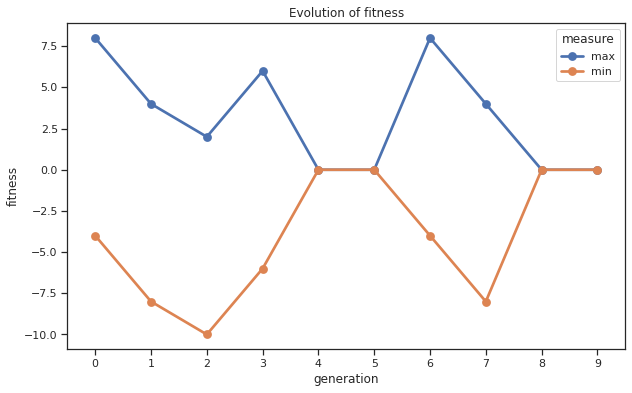

In [20]:
sns.pointplot(data_melted, x="generation", y="fitness", hue="measure")
_ = plt.title("Evolution of fitness")

#### Population evolution

In [16]:
max_fitness_index_per_generation = np.array([np.argmax(f) for f in evolution_fitnesses])
df_best_chromosomes = df_population.groupby("generation").apply(lambda x: x.iloc[max_fitness_index_per_generation[x.name]])

df_best_chromosomes.reset_index(drop=True, inplace=True)
df_best_chromosomes["generation"] = df_best_chromosomes.index

df_best_chromosomes.head()

,generation,coin_parity,actual_mobility,potential_mobility,corners_captured,future_corners_captured,static_weights
0,0,0.050428,0.252647,0.264117,0.074698,0.043990,0.314120
1,1,0.165951,0.066301,0.271378,0.269016,0.118892,0.108463
2,2,0.167284,0.254678,0.273558,0.075298,0.119847,0.109335
3,3,0.257721,0.089126,0.340655,0.105719,0.108132,0.098647
4,4,0.181781,0.096850,0.370176,0.114881,0.117503,0.118810


In [17]:
data_melted = df_best_chromosomes.melt(id_vars="generation", var_name="component", value_name='proportion')

data_melted.head()

,generation,component,proportion
0,0,coin_parity,0.050428
1,1,coin_parity,0.165951
2,2,coin_parity,0.167284
3,3,coin_parity,0.257721
4,4,coin_parity,0.181781


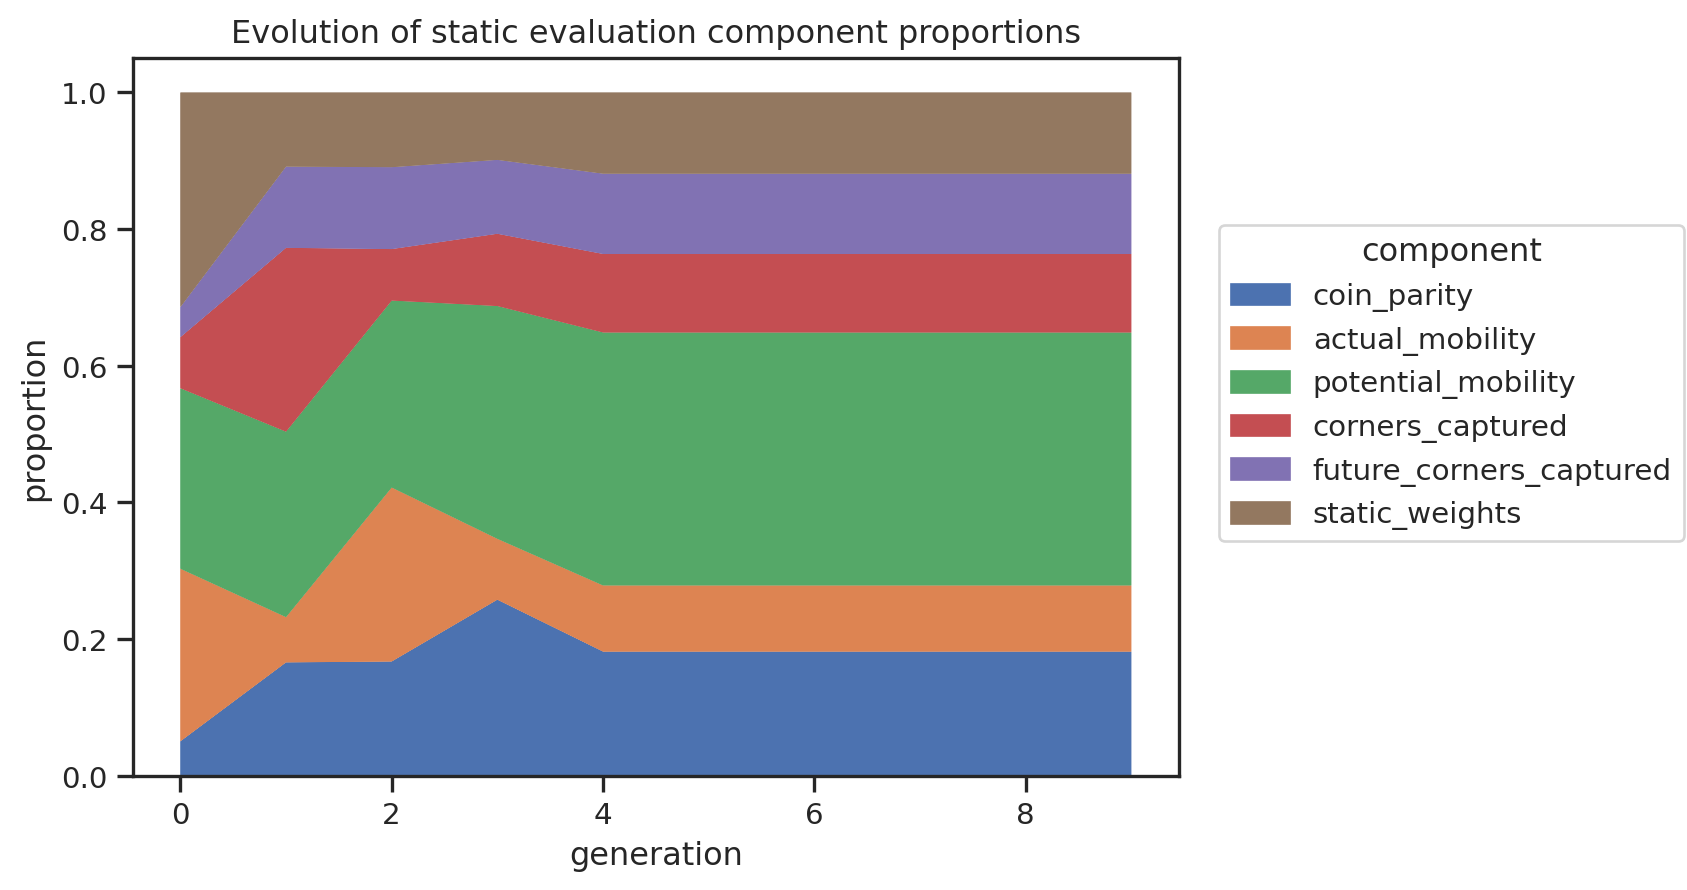

In [18]:
so.Plot(data_melted, x="generation", y="proportion", color="component")\
  .add(so.Area(alpha=1), so.Stack())\
  .label(title="Evolution of static evaluation component proportions")

### Save best chromosome

#### Directories

In [63]:
population_path = '../data/genetic_population_evolution.csv'
fitnesses_path = '../data/genetic_fitnesses_evolution.csv'
best_chromosome_path = '../data/genetic_best_chromosome.txt'

#### Save to txt

In [27]:
df_population = pd.read_csv(population_path)
df_population.tail()

,generation,coin_parity,actual_mobility,potential_mobility,corners_captured,future_corners_captured,static_weights
55,9,0.181781,0.09685,0.370176,0.114881,0.117503,0.11881
56,9,0.181781,0.09685,0.370176,0.114881,0.117503,0.11881
57,9,0.181781,0.09685,0.370176,0.114881,0.117503,0.11881
58,9,0.181781,0.09685,0.370176,0.114881,0.117503,0.11881
59,9,0.181781,0.09685,0.370176,0.114881,0.117503,0.11881


In [26]:
df_fitnesses = pd.read_csv(fitnesses_path)
df_fitnesses.tail()

,generation,chromosome_0,chromosome_1,chromosome_2,chromosome_3,chromosome_4,chromosome_5
5,5,0,0,0,0,0,0
6,6,8,8,-4,-4,-4,-4
7,7,4,4,-8,-8,4,4
8,8,0,0,0,0,0,0
9,9,0,0,0,0,0,0


In [56]:
last_generation_number = df_fitnesses["generation"].values[-1]

last_generation = df_population[df_population["generation"] == last_generation_number]
last_generation["fitness"] = df_fitnesses[df_fitnesses["generation"] == last_generation_number].values[0][1:]

last_generation.head()

/tmp/ipykernel_136472/2938237407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_generation["fitness"] = df_fitnesses[df_fitnesses["generation"] == last_generation_number].values[0][1:]


,generation,coin_parity,actual_mobility,potential_mobility,corners_captured,future_corners_captured,static_weights,fitness
54,9,0.181781,0.09685,0.370176,0.114881,0.117503,0.11881,0
55,9,0.181781,0.09685,0.370176,0.114881,0.117503,0.11881,0
56,9,0.181781,0.09685,0.370176,0.114881,0.117503,0.11881,0
57,9,0.181781,0.09685,0.370176,0.114881,0.117503,0.11881,0
58,9,0.181781,0.09685,0.370176,0.114881,0.117503,0.11881,0


In [61]:
best_fitness_index = np.argmax(last_generation["fitness"].values)
best_chromosome = last_generation.values[best_fitness_index][1:-1]

best_chromosome

array([0.18178101, 0.09684959, 0.3701763 , 0.11488076, 0.11750276,
       0.1188096 ])

In [67]:
np.savetxt(best_chromosome_path, best_chromosome)